# Seminar 2

In [9]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import arviz as az
import pytensor
import pytensor.tensor as pt
import warnings
warnings.filterwarnings("ignore")
az.style.use("arviz-white")

$$
Y = A L^\beta
$$

In [10]:
np.random.seed(42)
β = 0.5
Lm = np.linspace(10, 40, 6)
A = 15/Lm

L = np.exp(np.random.normal(np.log(Lm), 0.4, size=(20, len(Lm))))
Y = A * L ** β
Y += np.random.randn(*Y.shape) * 0.5
data = pd.DataFrame(dict(
    L=L.T.flatten(), Y=Y.T.flatten(), G=np.repeat(range(len(Lm)), Y.shape[0])
))

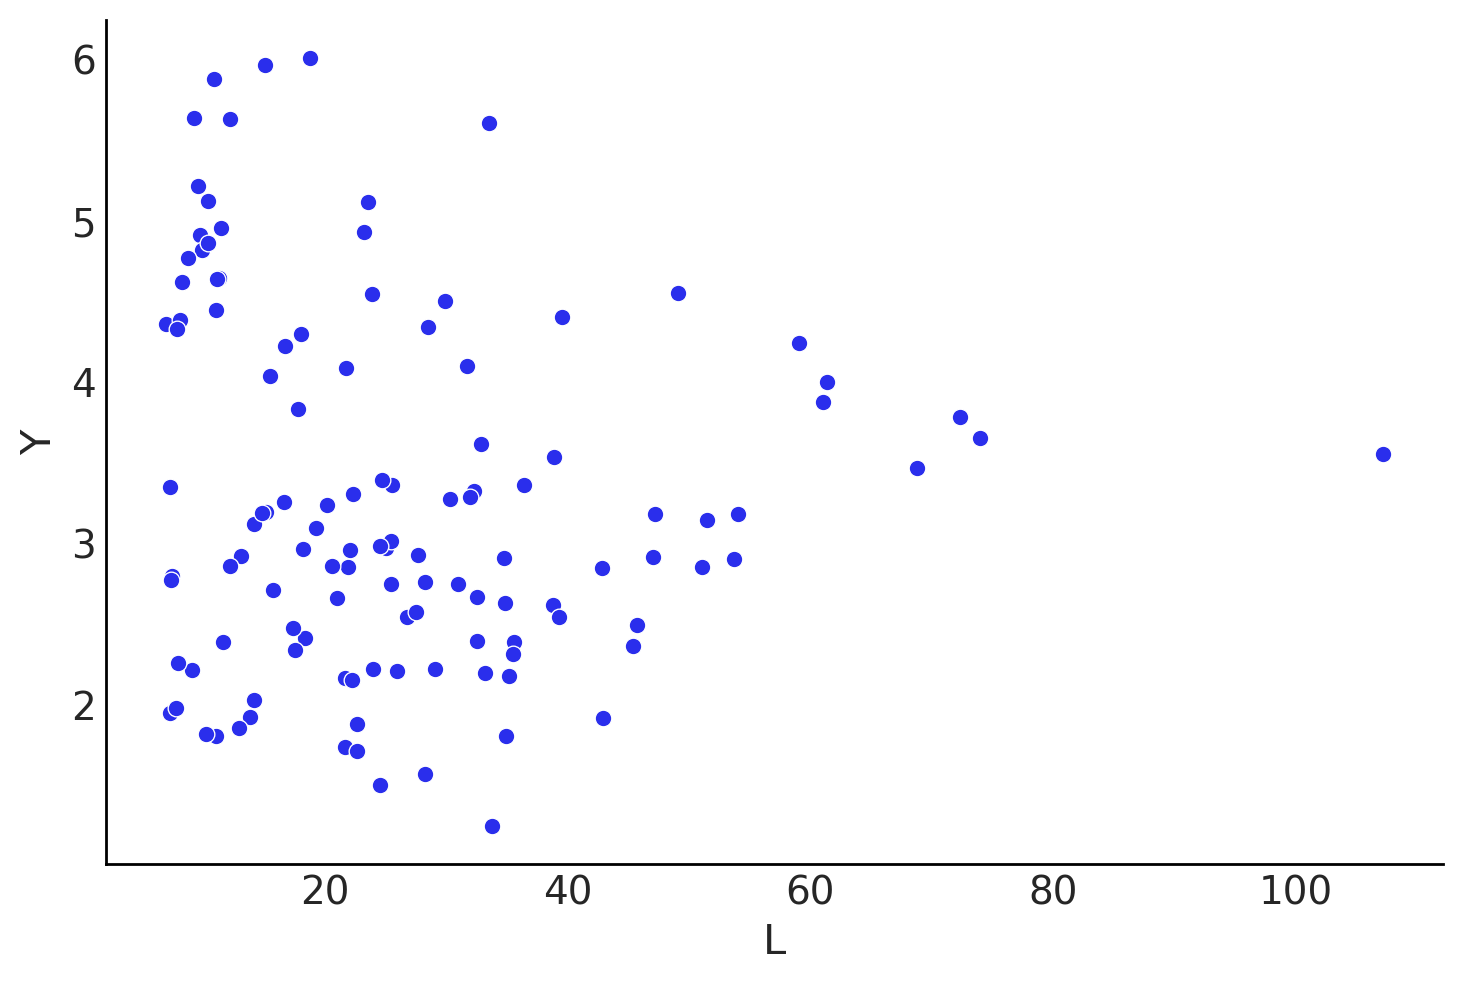

In [11]:
sns.scatterplot(x="L", y="Y", data=data);

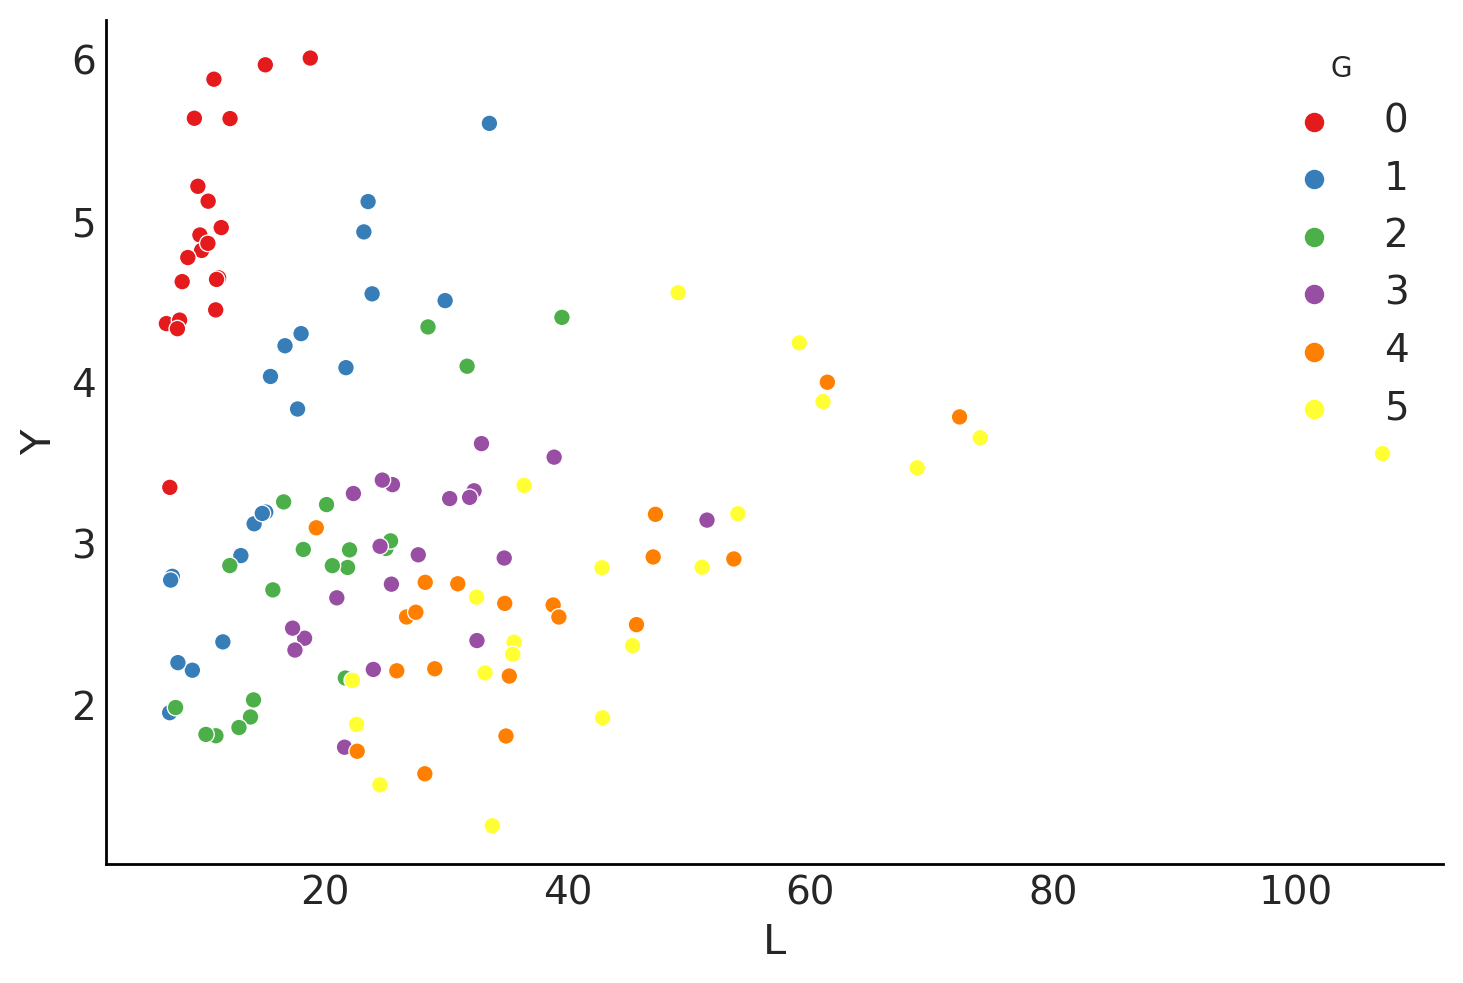

In [12]:
sns.scatterplot(x="L", y="Y", hue="G", data=data, palette="Set1");

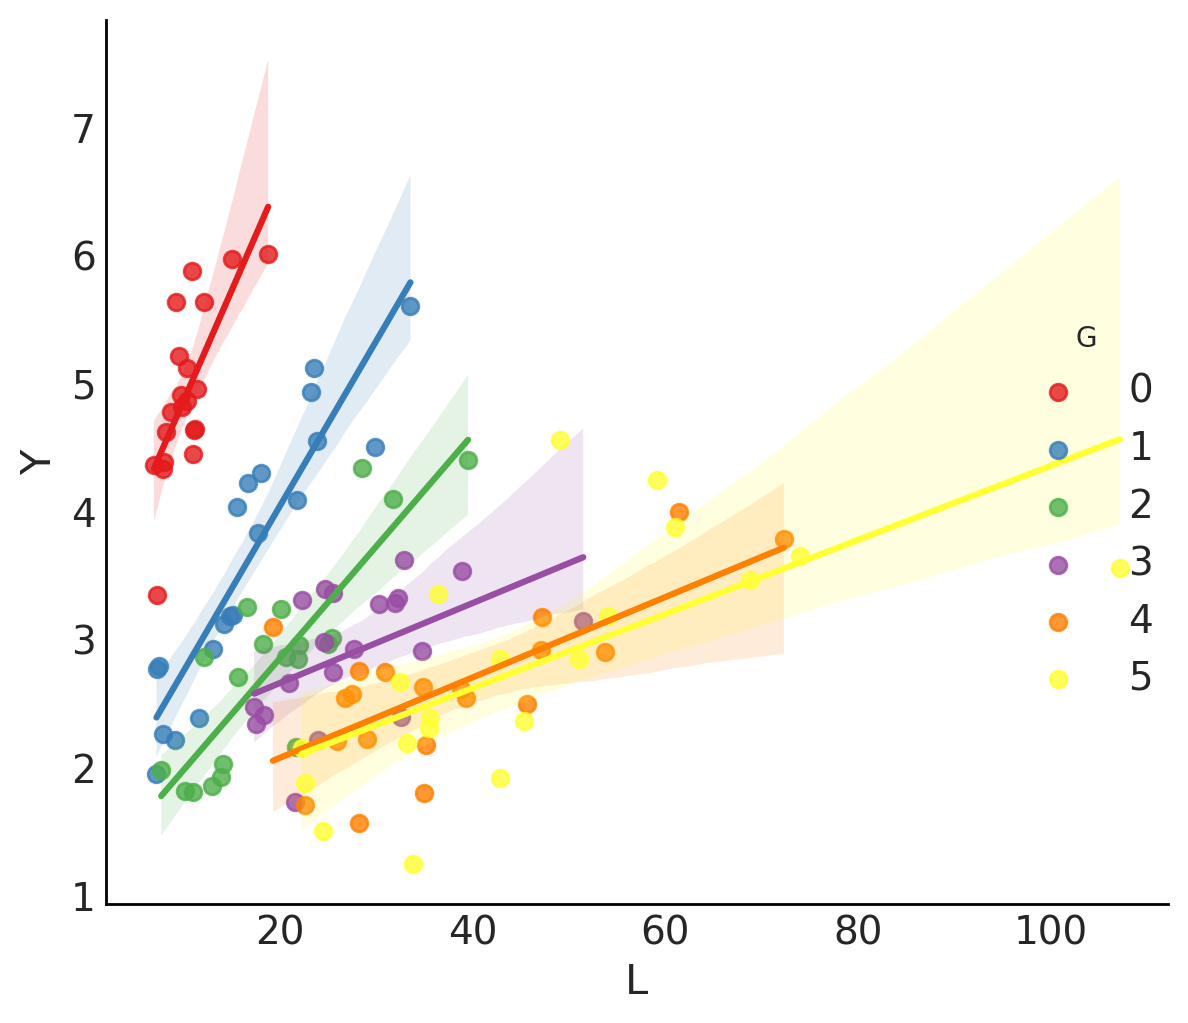

In [13]:
sns.lmplot(x="L", y="Y", hue="G", data=data, palette="Set1");

[]

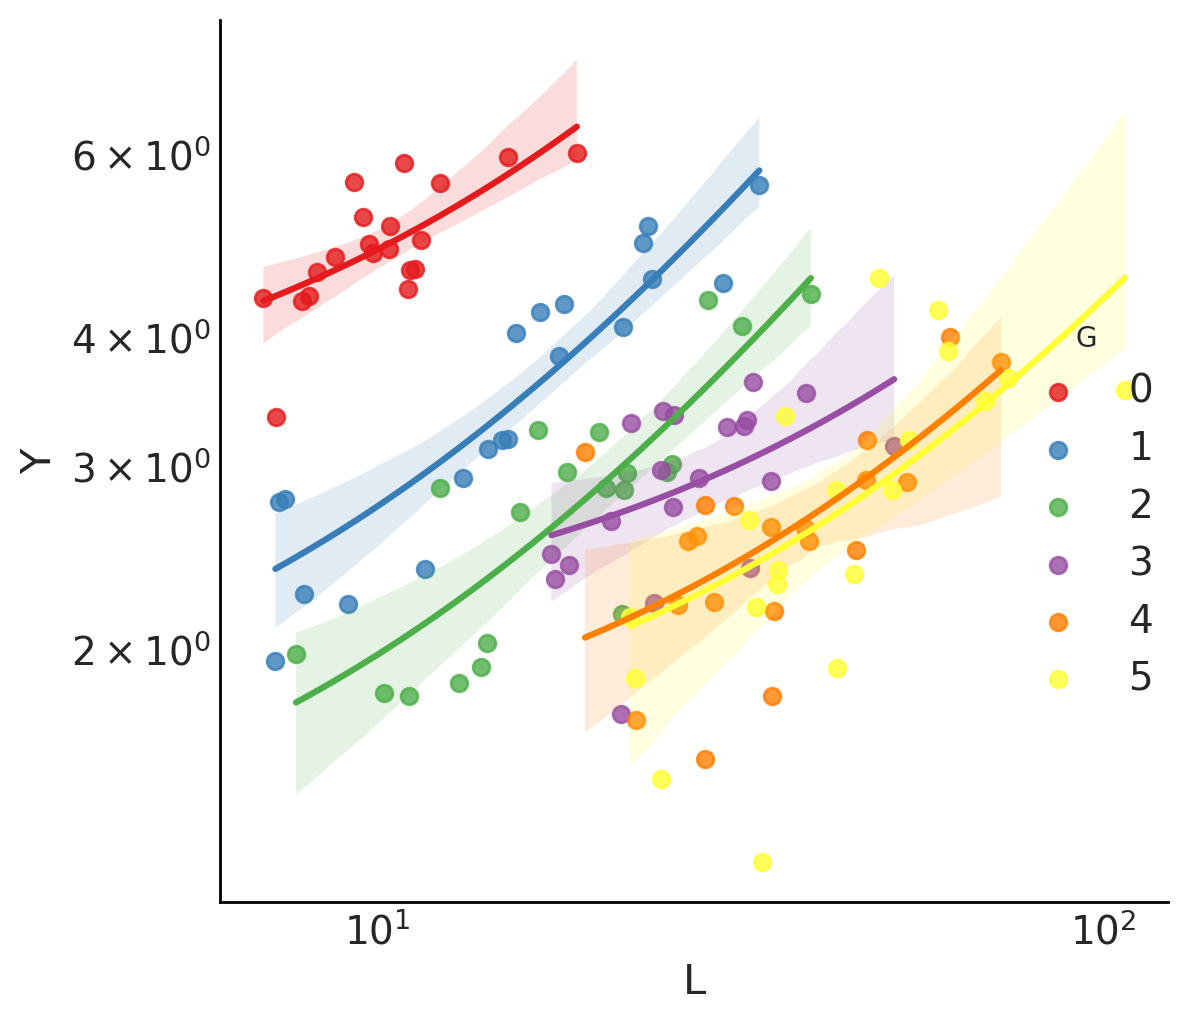

In [14]:
sns.lmplot(x="L", y="Y", hue="G", data=data, palette="Set1");
plt.loglog()

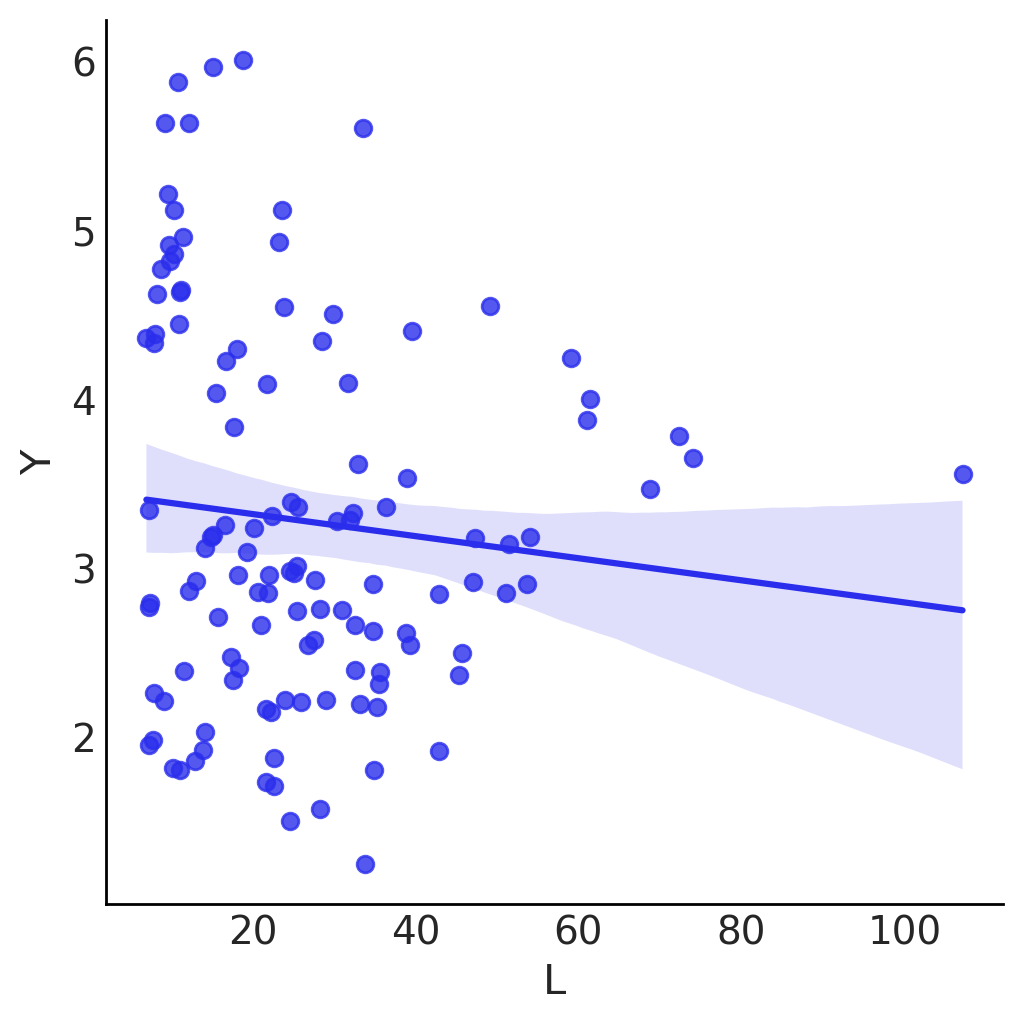

In [15]:
sns.lmplot(x="L", y="Y", data=data);

## One Group Model

### Priors

<Axes: ylabel='Density'>

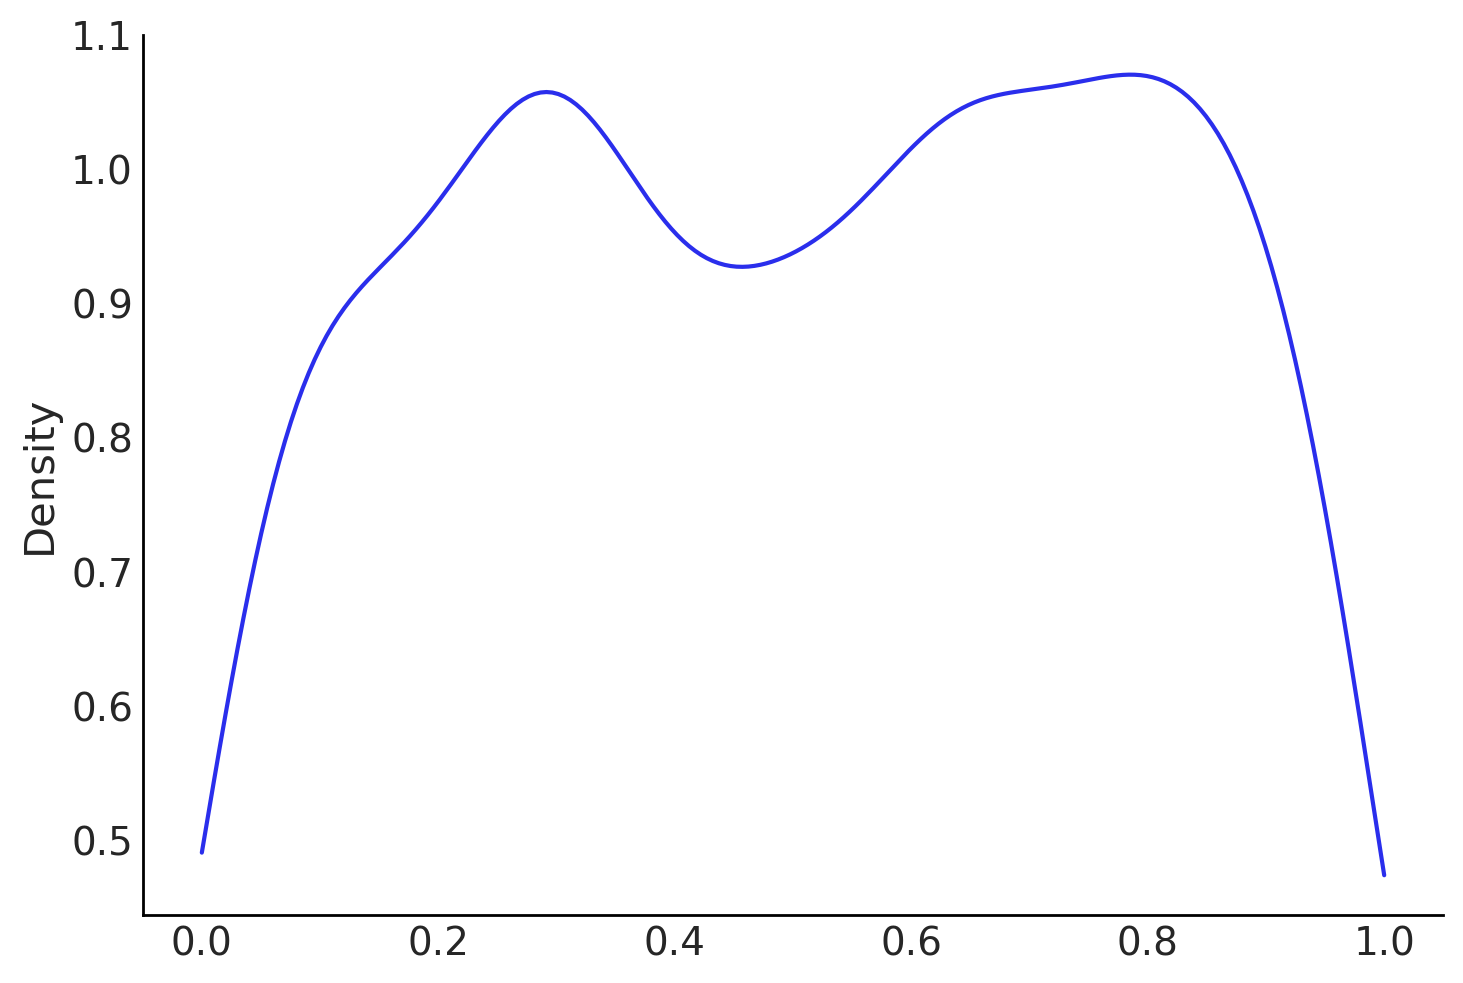

In [16]:
sns.kdeplot(pm.Uniform.dist(size=1000).eval(), clip=[0, 1])

<AxesSubplot:ylabel='Density'>

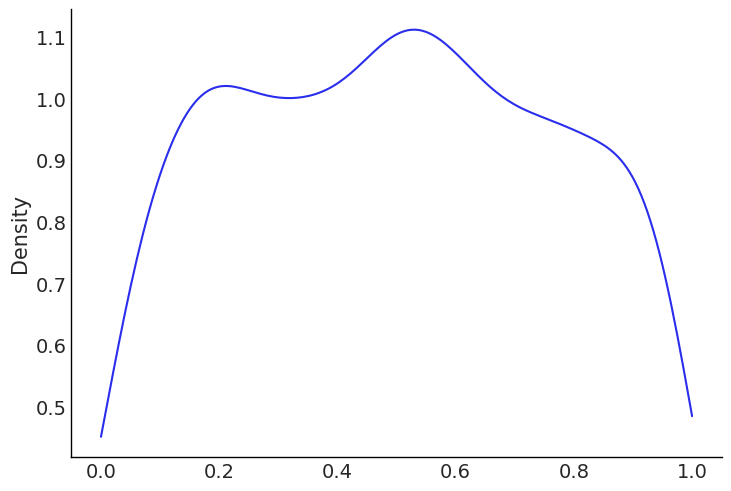

In [190]:
sns.kdeplot(pm.Beta.dist(1, 1, size=1000).eval(), clip=[0, 1])

<AxesSubplot:ylabel='Density'>

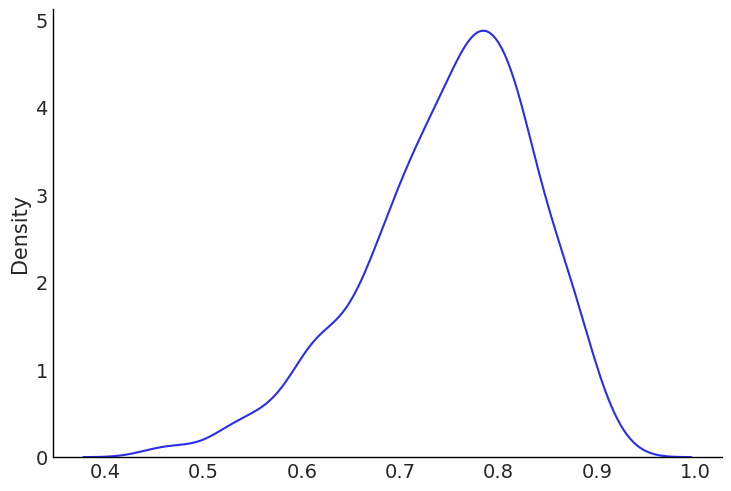

In [191]:
sns.kdeplot(pm.Kumaraswamy.dist(10, 10, size=1000).eval(), clip=[0, 1])

<AxesSubplot:ylabel='Density'>

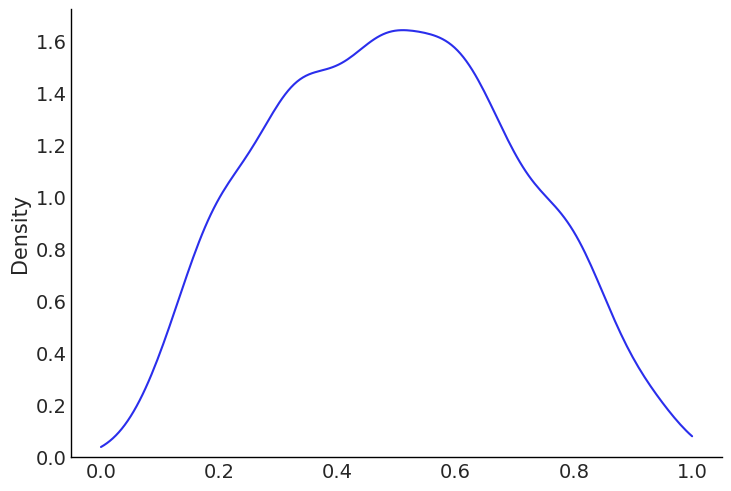

In [192]:
sns.kdeplot(pm.LogitNormal.dist(size=1000).eval(), clip=[0, 1])

$$
\begin{align*}
    \log Y_{g=0} &\sim \operatorname{Normal}(\log A_{g=0} + \log L \cdot \beta, \varepsilon)\\
    \varepsilon &\sim \operatorname{LogNormal}(-2, 1)\\
    \beta &\sim \operatorname{LogitNormal}(0, 1)\\
    A_{g=0} &\sim \operatorname{LogNormal}(0, 1)\\
\end{align*}
$$

In [17]:
data0 = data.query("G==0")

In [18]:
data0

L         Y  G
0   12.197985  5.634358  0
1   18.807773  6.009921  0
2   11.016234  4.447455  0
3    6.954406  4.362440  0
4    8.043240  4.384032  0
5    7.860911  4.330844  0
6   10.871346  5.878646  0
7    9.547943  5.214260  0
8   11.473413  4.958170  0
9   15.104382  5.967999  0
10   8.255795  4.622769  0
11   9.716068  4.912210  0
12   9.857718  4.816597  0
13  10.373862  4.860376  0
14   7.236862  3.346378  0
15  10.395948  5.121857  0
16  11.257485  4.646414  0
17   8.718954  4.772311  0
18  11.085138  4.636501  0
19   9.259413  5.636365  0

In [19]:
with pm.Model() as model1:
    a = pm.LogNormal("A", 0, 1)
    b = pm.LogitNormal("beta", 0, 1)
    e = pm.LogNormal("e", -2, 1)
    y = pm.LogNormal("obs", pt.log(a) + np.log(data0.L), e, observed=data0.Y)

In [20]:
with model1:
    prior = pm.sample_prior_predictive()

Sampling: [A, beta, e, obs]


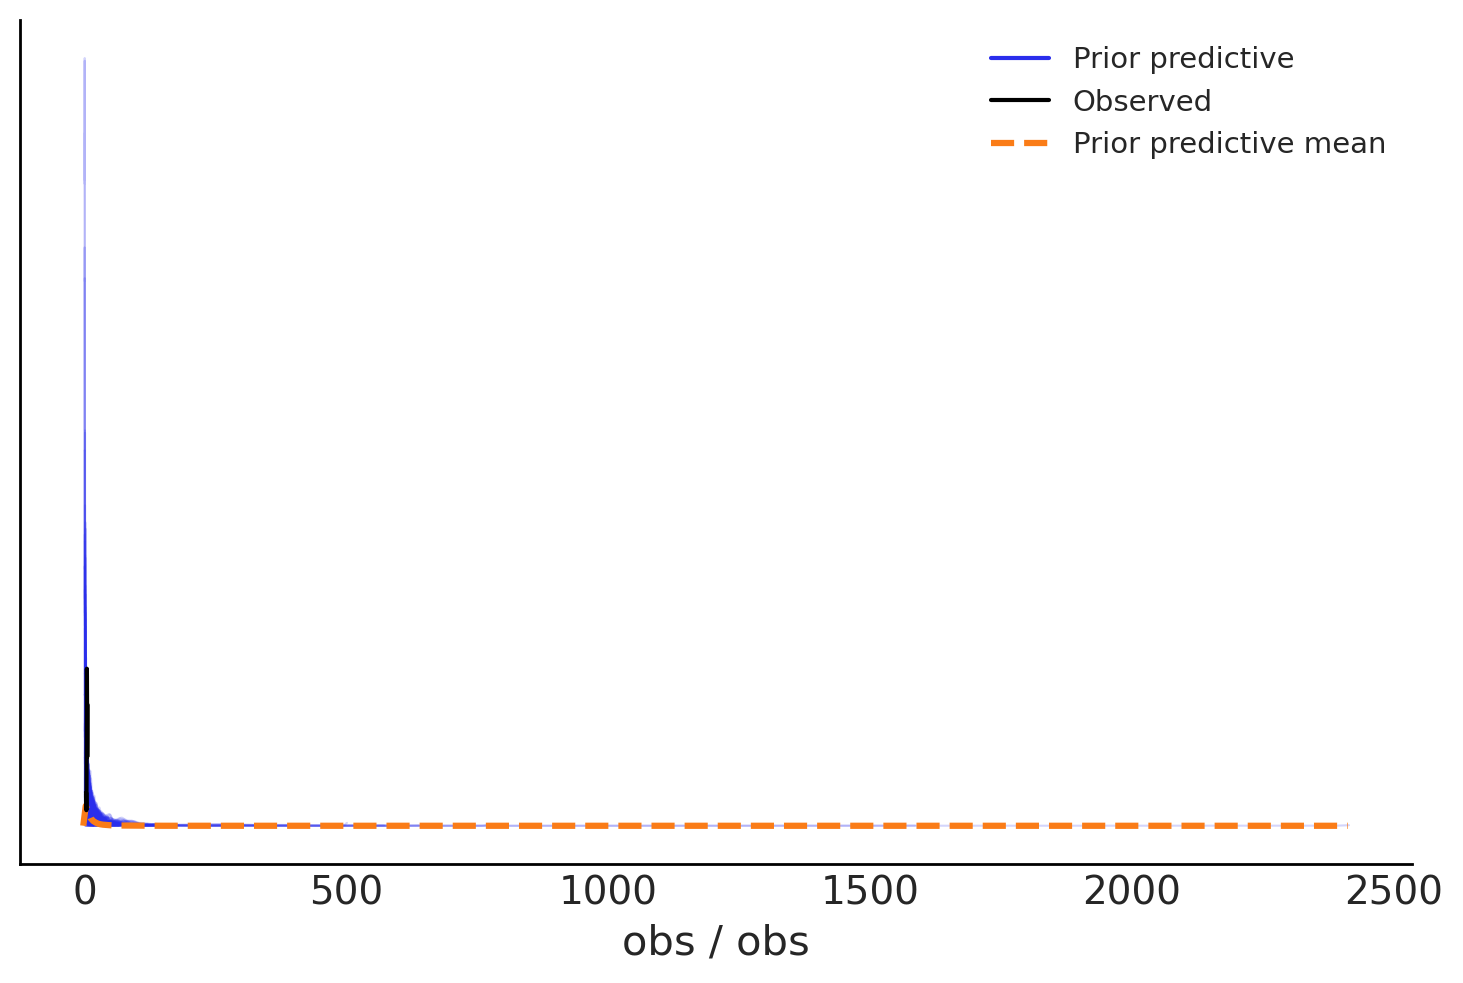

In [21]:
az.plot_ppc(prior, group="prior", observed=True)

In [22]:
with model1:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, beta, e]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


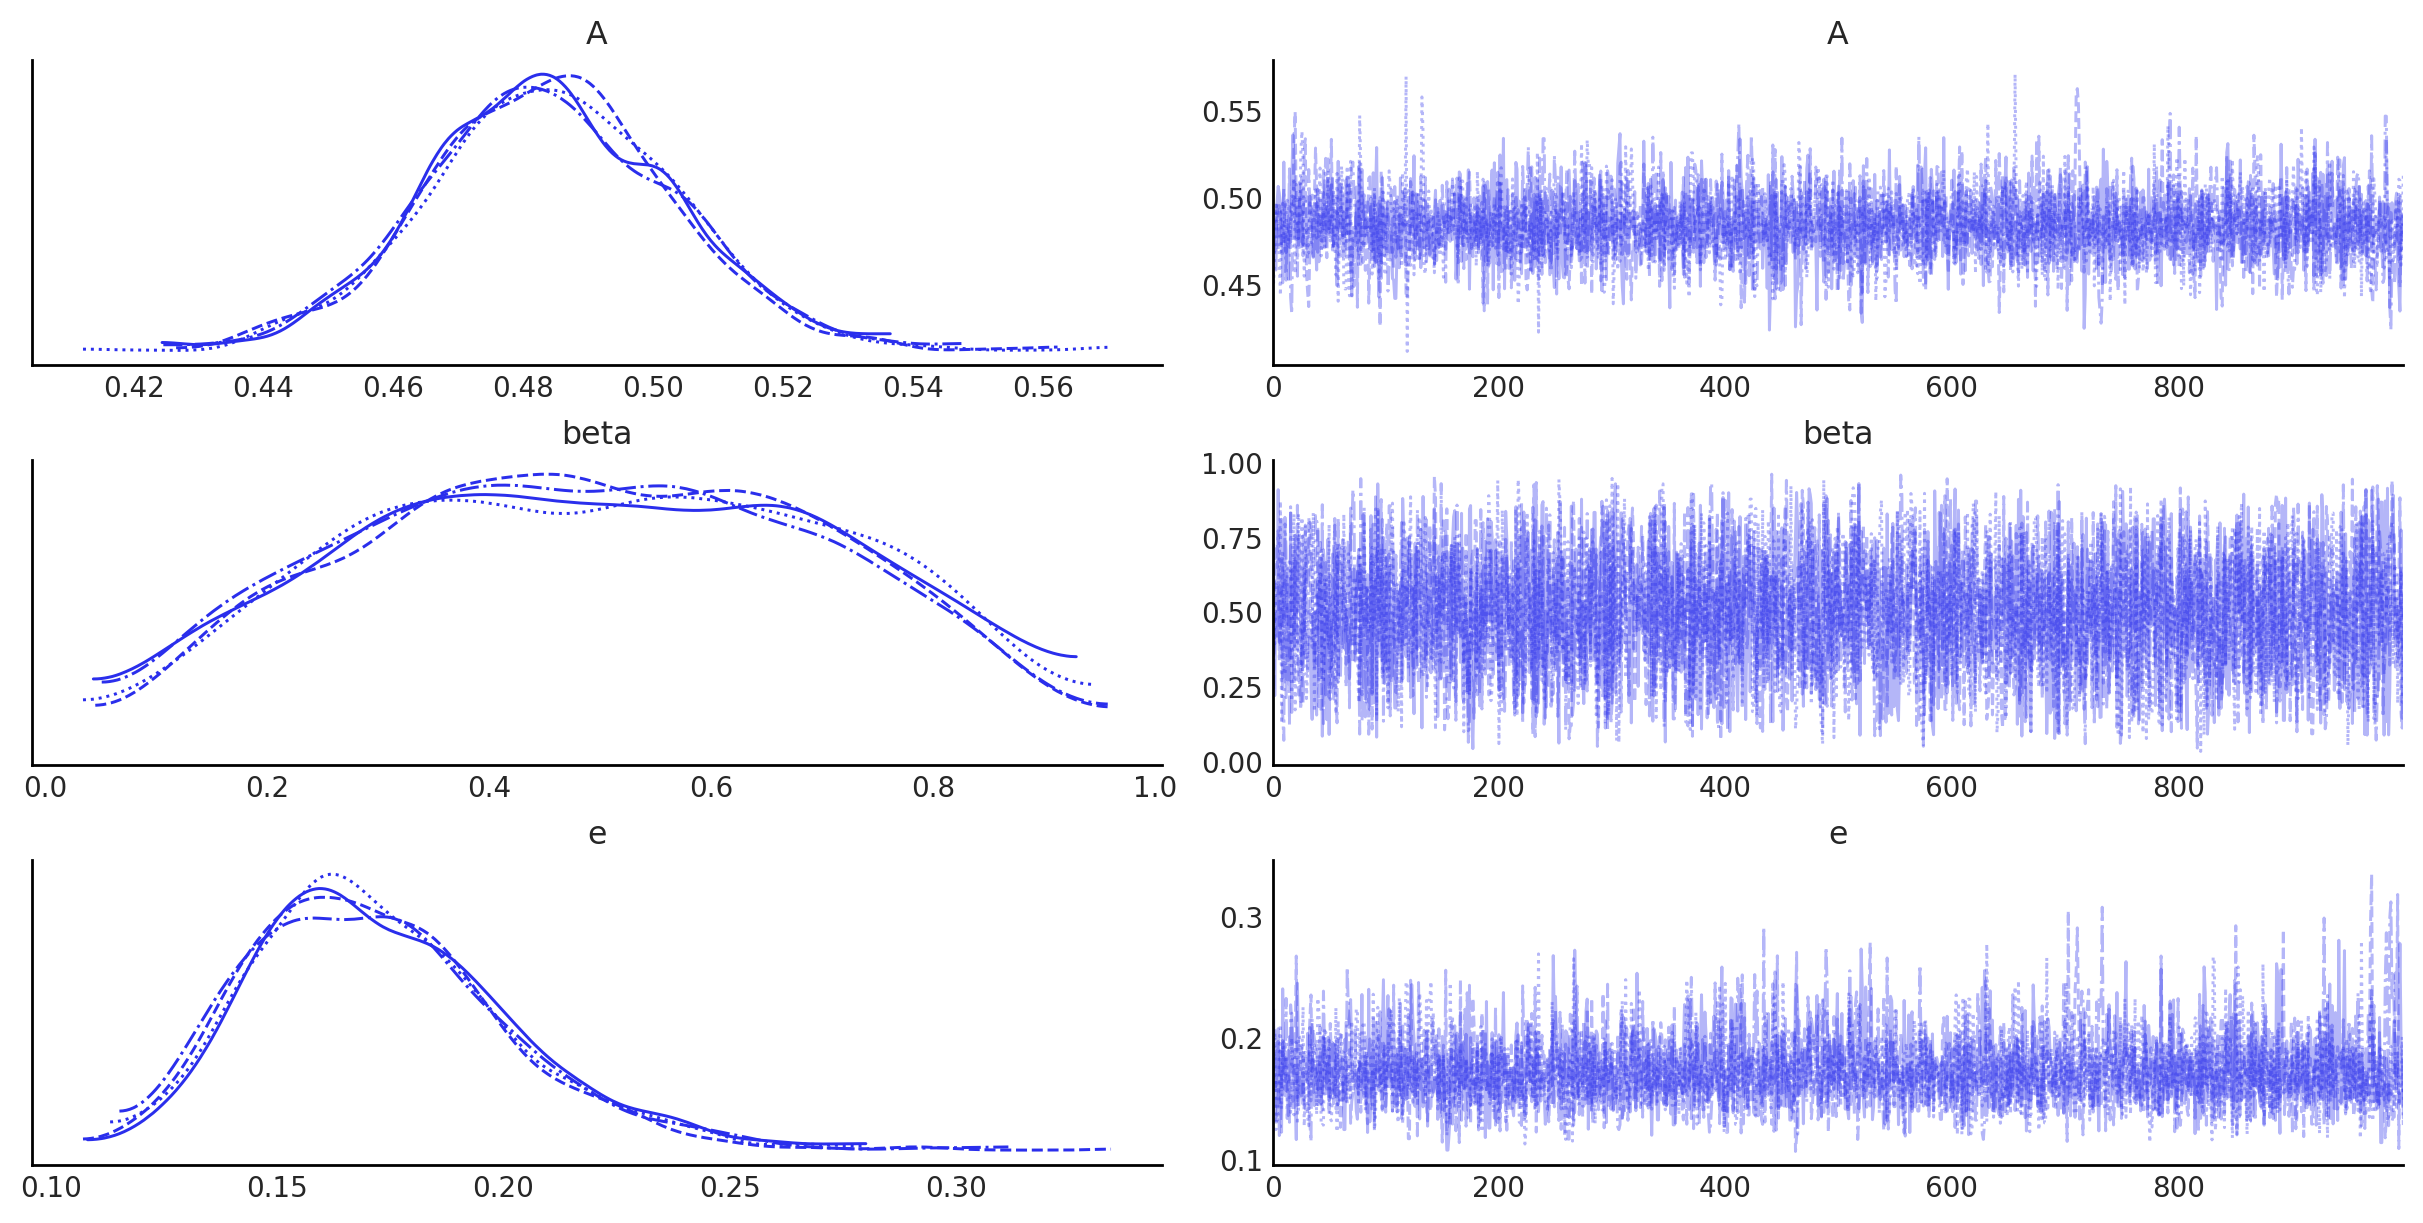

In [25]:
az.plot_trace(trace);

### Fixing Priors

Sampling: [A, beta, e, obs]


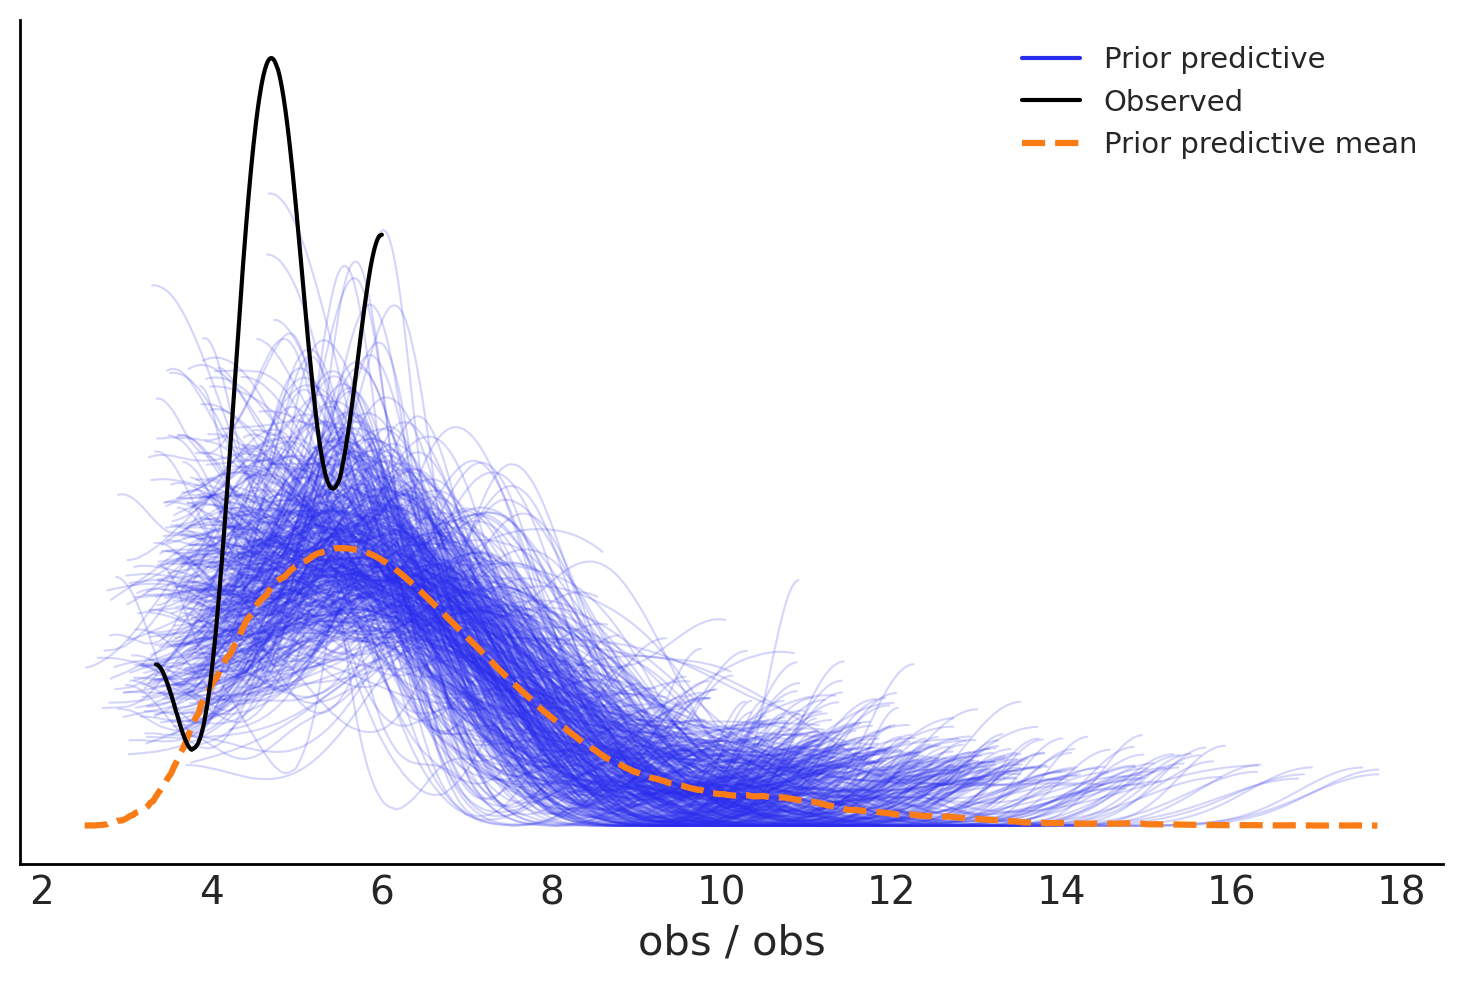

In [26]:
with pm.Model() as model1:
    a = pm.LogNormal("A", -0.5, 0.1)
    b = pm.LogitNormal("beta", 0, 1)
    e = pm.LogNormal("e", -2, 0.1)
    y = pm.LogNormal("obs", pt.log(a) + np.log(data0.L), e, observed=data0.Y, )
    prior = pm.sample_prior_predictive()
    az.plot_ppc(prior, group="prior", observed=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, beta, e]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


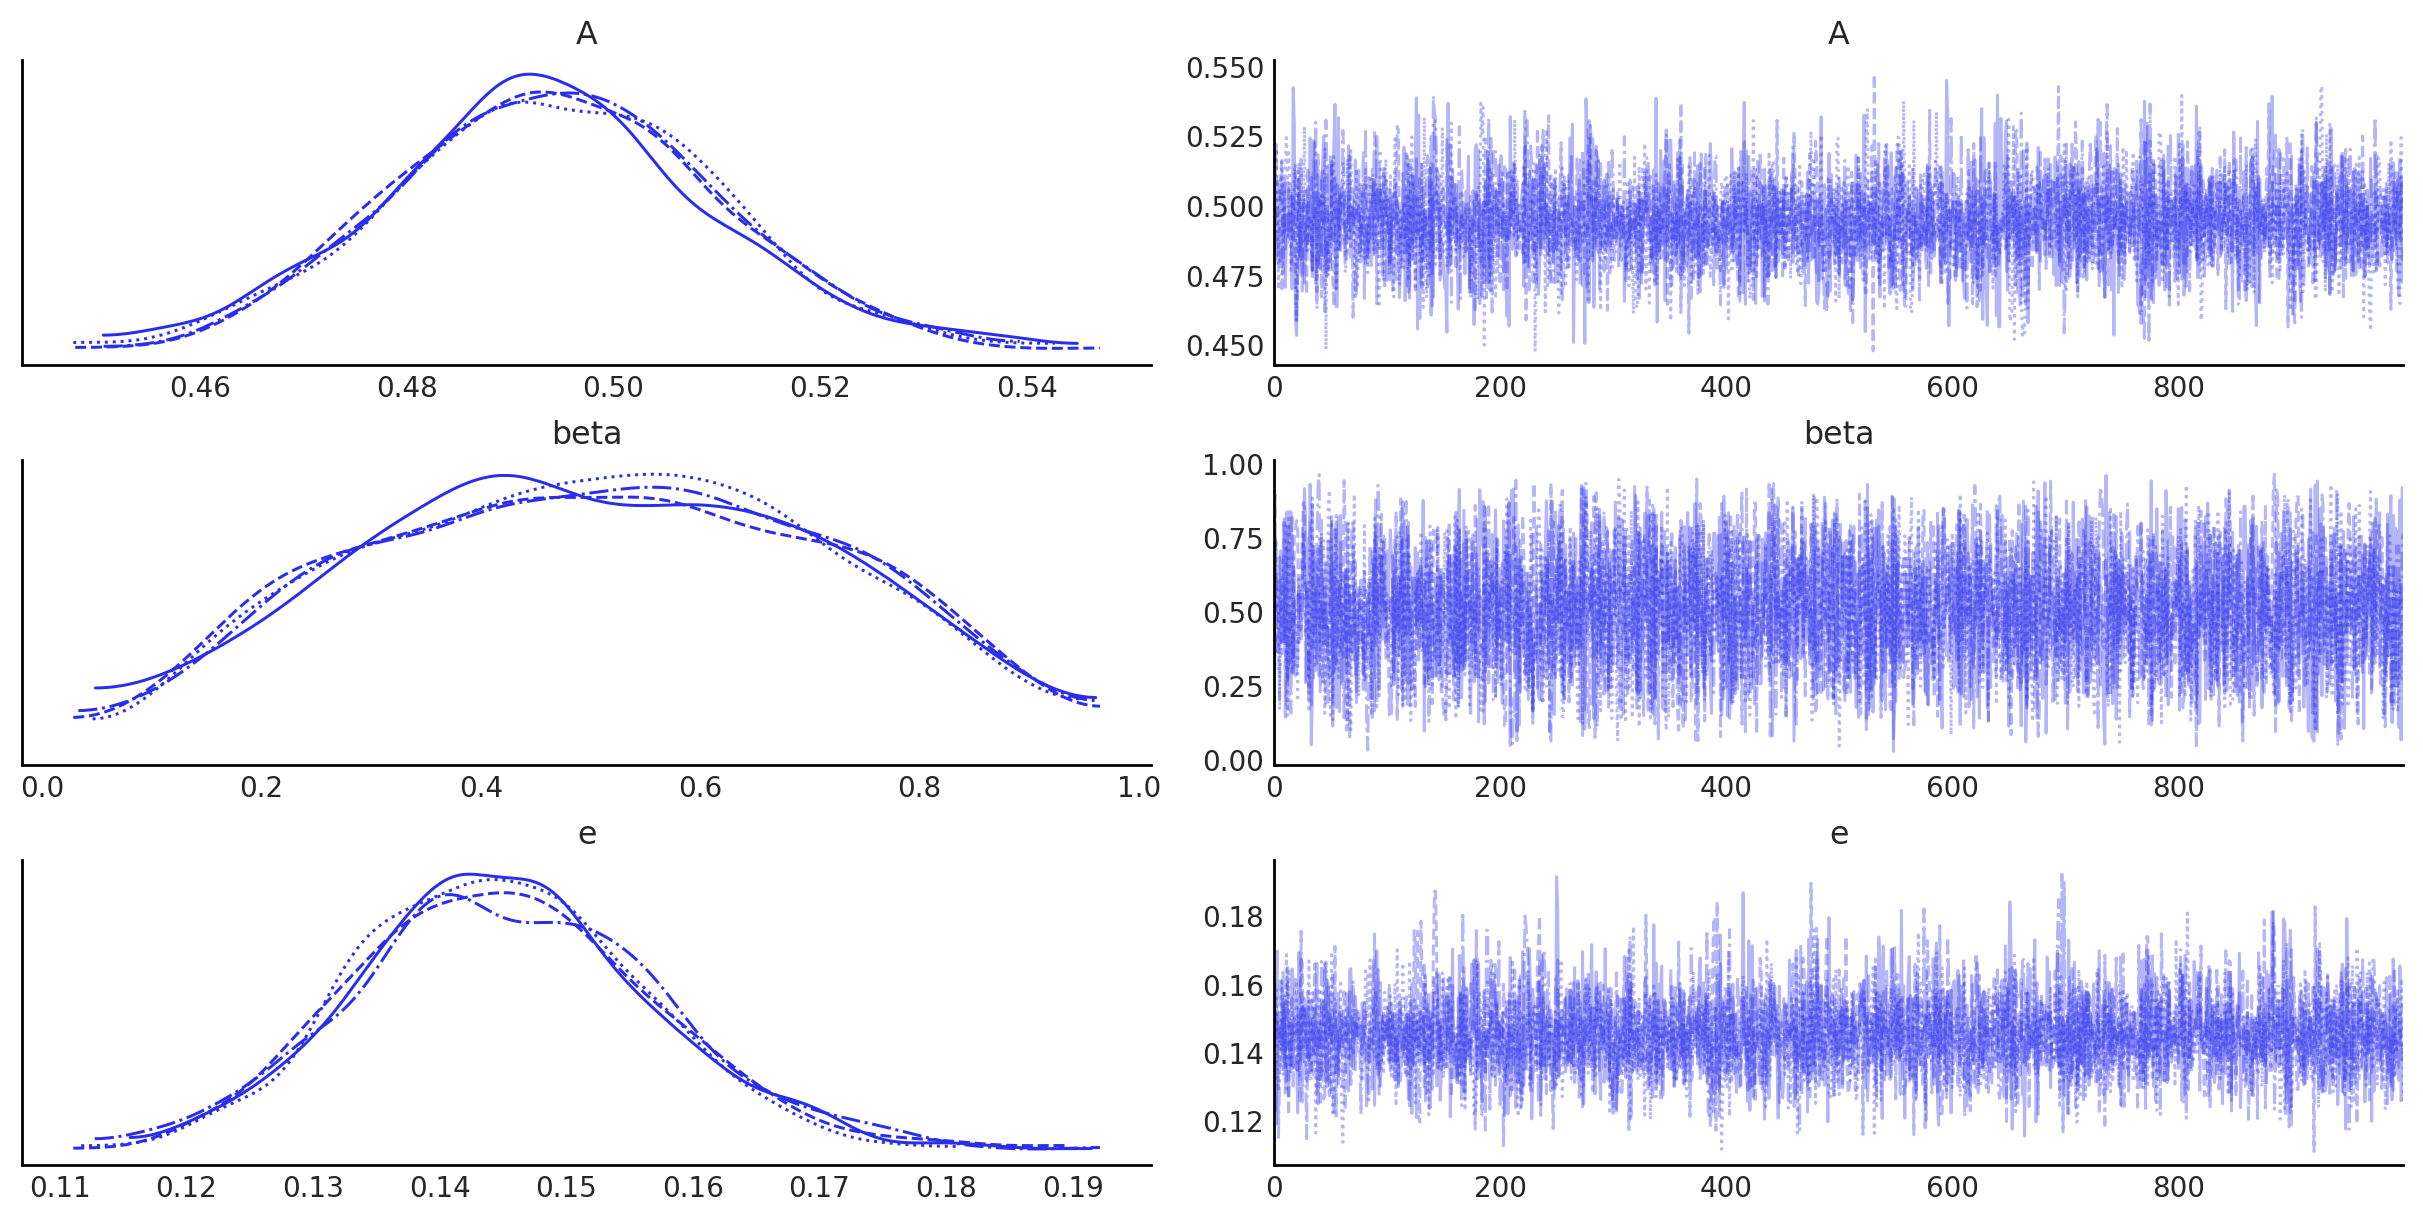

In [27]:
with model1:
    trace = pm.sample()
    az.plot_trace(trace)

## Neal's Funnel

$$
\begin{align}
s &\sim \operatorname{HalfCauchy}(1)\\
m &\sim \operatorname{Normal}(0, s)
\end{align}
$$

In [37]:
with pm.Model() as neals_funnel:
    s = pm.Exponential("s", 1)
    m = pm.Normal("m", 0, s)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 722 divergences after tuning. Increase `target_accept` or reparameterize.


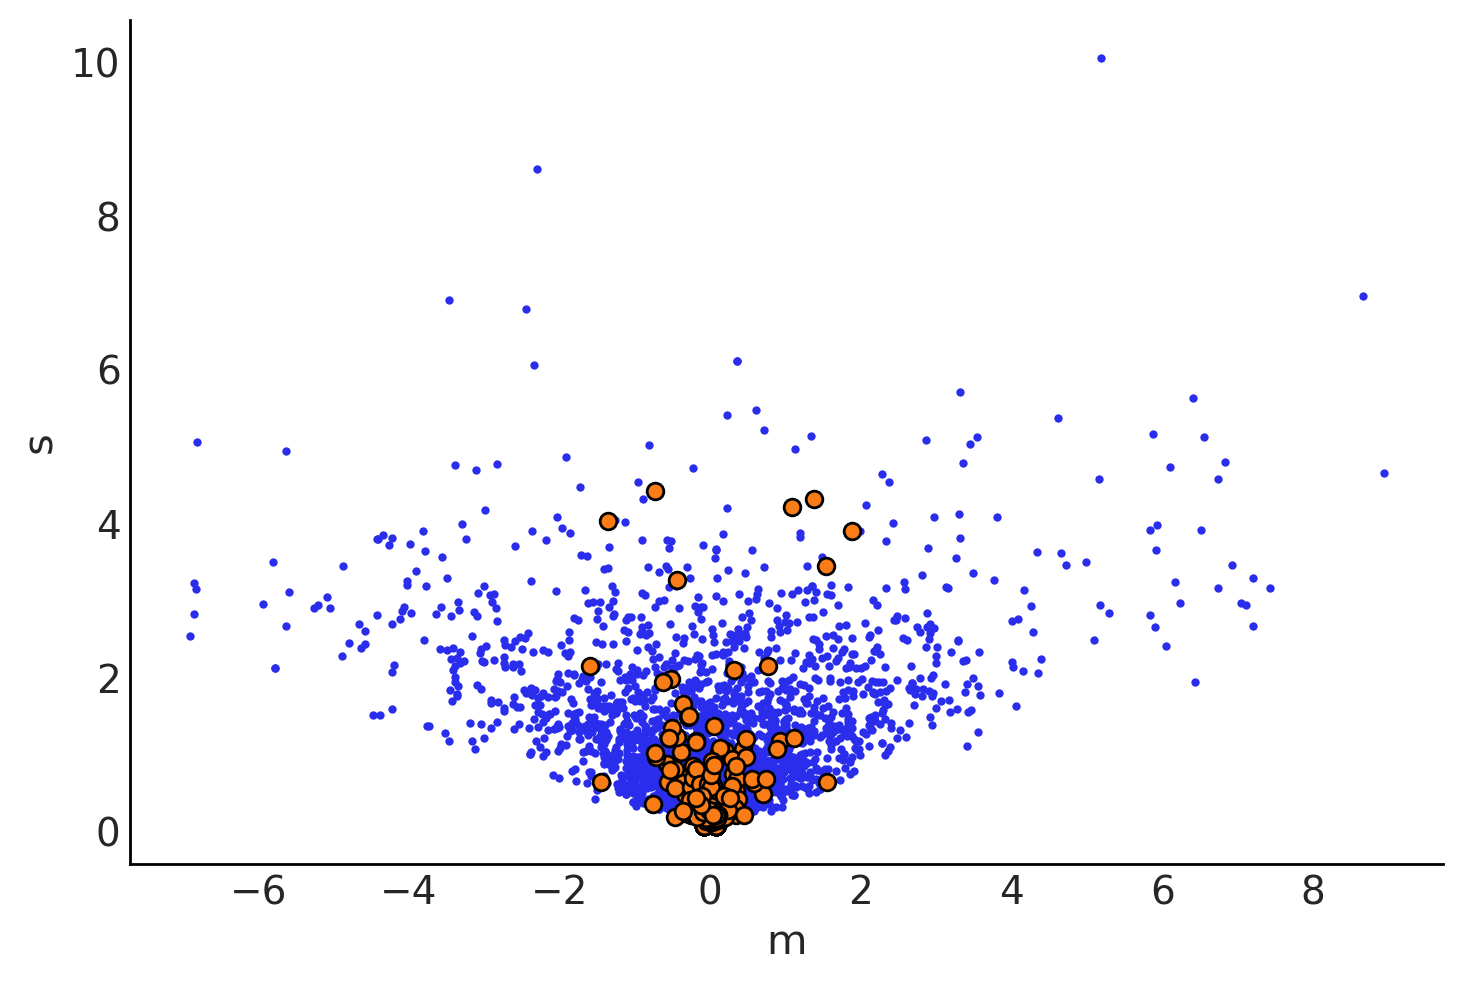

In [38]:
az.plot_pair(trace, divergences=True);

In [40]:
with pm.Model() as no_neals_funnel:
    s = pm.Exponential("s", 1)
    m = pm.Deterministic("m", pm.Normal("m̄") * s)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, m̄]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


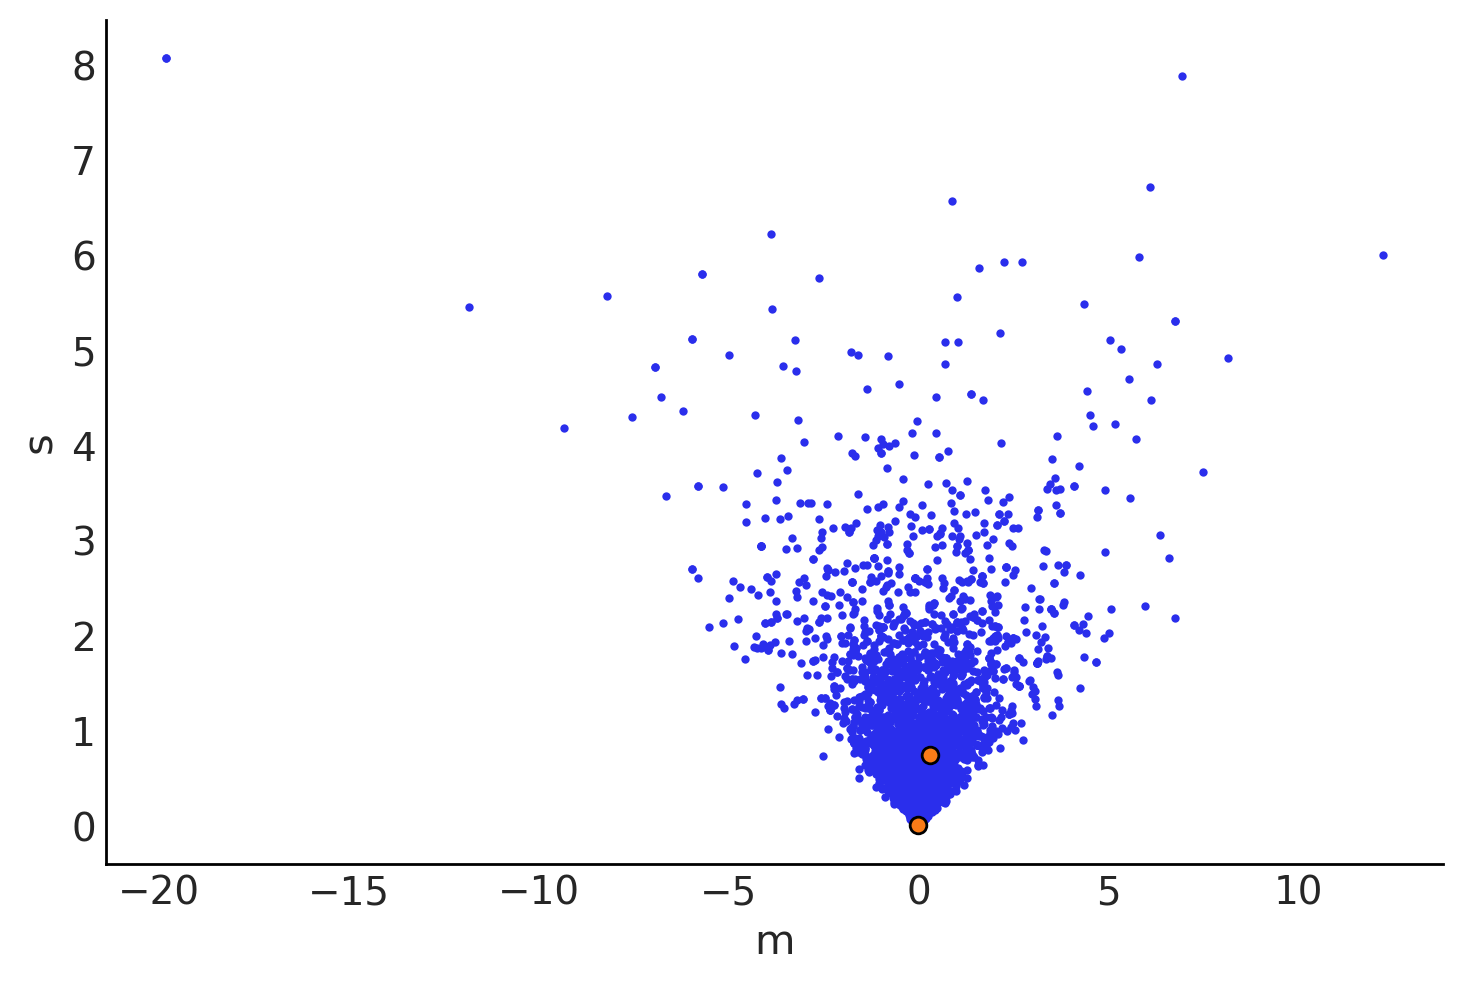

In [41]:
az.plot_pair(trace, var_names=["m", "s"], divergences=True);

$$
\begin{align}
s &\sim \operatorname{HalfCauchy}(1)\\
\bar m &\sim \operatorname{Normal}(0, 1)\\
m &= s \bar m
\end{align}
$$

## Hierarchical Model

Sampling: [Apop, a, a_sigma, beta, e, obs]


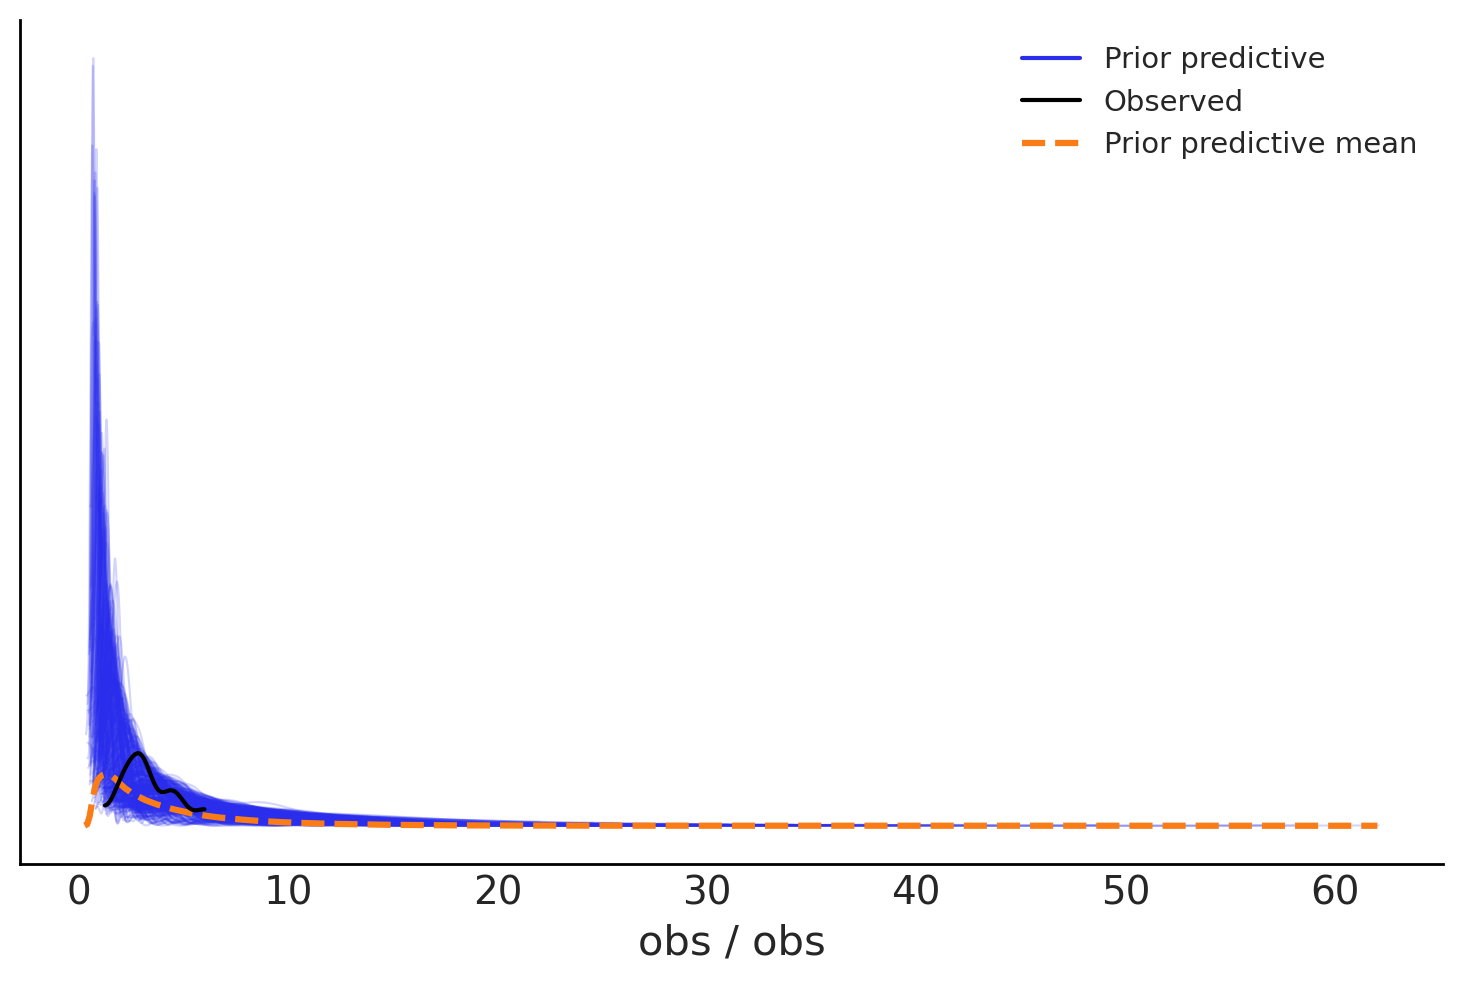

In [44]:
with pm.Model(coords=dict(group=data.G.unique(), idx=data.index)) as model2:
    apop = pm.LogNormal("Apop", -0.5, 0.1)
    a_sigma = pm.Exponential("a_sigma", 10)
    a = pm.LogNormal("a", pt.log(apop), a_sigma, dims="group")
    # a (group, )
    b = pm.LogitNormal("beta", 0, 1)
    e = pm.LogNormal("e", -2, 0.1)
    y = pm.LogNormal("obs", pt.log(a[data.G.values]) + np.log(data.L.values) * b, e, observed=data.Y, dims="idx")
    prior = pm.sample_prior_predictive()
    az.plot_ppc(prior, group="prior");